# Osteisarcoma Label Cleaning Multiple Instance Learning

#### 0. Import Packages

In [46]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from scipy.stats import binom
import cv2 as cv
import numpy as np
from skimage import morphology
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import random
import openslide
import numpy as np
import random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import cv2 as cv
from skimage import morphology
import matplotlib.pyplot as plt
import wandb
import os
from os.path import basename
import json 
import pandas as pd
import itertools

#### 1. Basic Slide information 

In [2]:
# Path to your WSI file
wsi_path_1 = '/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-15 18.31.27.ndpi'
wsi_label_path_1 = "/export/io86/data/jhu101/OTS-23-17323 - 2023-06-15 18.31.27.ndpi.xml"

#Open the WSI file
slide = openslide.OpenSlide(wsi_path_1)
# print(f"Slide Level Count:{slide.level_count}")
# print(f"Slide Dimensions:{slide.dimensions}")
# print(f"Slide level dimensions:{slide.level_dimensions}")

# 1.Generate Tissue Mask

In [3]:
def binary_Aaron(img,adjust_otsu, fill_size=50, remove_size=50):
    # 16714505 1.21
    # 16714503 1.25
    #Changing the BGR Channel to Gray
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    #Setting a threhold where >threhold =255; <threhold =0. This is for denoising
    otsu_threshold, _ = cv.threshold(gray, 0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    #Apply to our downsampling WSI
    binary = gray<= (otsu_threshold*adjust_otsu)
    #Don't quite understand this part? Why should we do this.
    binary = morphology.remove_small_objects(morphology.remove_small_holes(binary, fill_size),remove_size)
    return binary

    

In [4]:
def generate_tissue_mask(slide_ob,unit,adjust_otsu):
    """
    Generate tissue mask (downsampled) for WSI
    - Input
        slide_ob: slide object
        unit: downsample scale
        adjust_otsu: adjust the OTSU threshold
    - Return
        mask tissue
    """
    #Get the width and height of WSI
    width,height = slide_ob.dimensions
    #Get the downsampling width and height of WSI
    width_downsample, height_downsample = width//unit, height//unit
    #Get the thumnail with respect to the down-sampling WSI 
    thumbnail = slide_ob.get_thumbnail((width_downsample,width_downsample))
    #Using opencv to resize the thumnial. Aim to convert the image to numpy array
    thumbnail = cv.resize(np.array(thumbnail)[:,:,:3],(width_downsample,height_downsample))
    #Use binary to denoise our image and convert it to numpy array
    mask_tissue = np.array(binary_Aaron(thumbnail, adjust_otsu),dtype=np.uint8) 
    return mask_tissue


In [5]:
#Generate label mask
def generate_label_mask(slide_ob, annotations, annotation_label_mapping, unit):
    """
    Generate label mask (downsampled) for WSI
    - Input
        slide_ob: slide object
        annotations: {'annotation_key':{'outer': [(x,y),....],'inner':[(x,y),...]}}
        'annotation_label_mapping': {'annotation_key': int}
        unit: downsample scale
    - Return
        Mask: label mask
    """
    width, height = slide_ob.dimensions
    Mask = np.zeros((int(height/unit),int(width/unit)),dtype=float)
    for annotation_key in annotations.keys():
        mask =  Image.new('1', (int(np.round(width/unit)),int(np.round(height/unit))))
        draw = ImageDraw.Draw(mask)
        for contour in annotations[annotation_key]['outer']:
            contour = [(i[0]/unit,i[1]/unit) for i in contour]
            draw.polygon(contour,fill=1,outline=0)
        for contour in annotations[annotation_key]['inner']:
            contour = [(i[0]/unit,i[1]/unit) for i in contour]
            draw.polygon(contour,fill=0,outline=0)
        mask = np.array(mask)
        Mask[mask==1] = annotation_label_mapping[annotation_key]
    return Mask

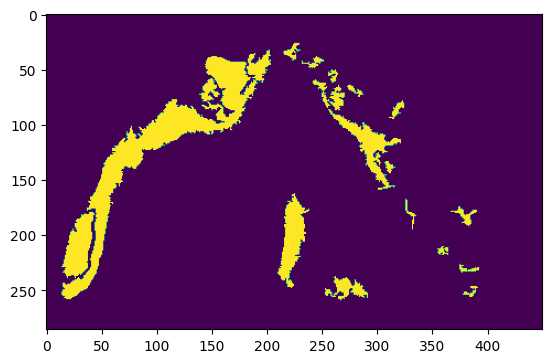

In [6]:
adjust_otsu =1
mask_tissue = generate_tissue_mask(slide,256,adjust_otsu)
plt.imshow(mask_tissue)
plt.show()

# 2. Generate Mask Label

In [7]:
def generate_label_mask(slide_ob, annotations, annotation_label_mapping, unit):
    """
    Generate label mask (downsampled) for WSI
    - Input
        slide_ob: slide object
        annotations: {'annotation_key':{'outer': [(x,y),....],'inner':[(x,y),...]}}
        'annotation_label_mapping': {'annotation_key': int}
        unit: downsample scale
    - Return
        Mask: label mask
    """
    #Get the width and height of our WSI
    width, height = slide_ob.dimensions
    #Build an empty label mask matrix for storing the labels later
    Mask = np.zeros((int(height/unit),int(width/unit)),dtype=float)
    #Find the labels for each classes: Viable, necrosis and stroma
    for annotation_key in annotations.keys():
      #Create a new image with mode 1(1-bit pixels,black and white)
        mask =  Image.new('1', (int(np.round(width/unit)),int(np.round(height/unit))))
        #Draw the labels for each class
        draw = ImageDraw.Draw(mask)
        #Get the coordinates information for each location inside one class
        for contour in annotations[annotation_key]['outer']:
          #Consider the downsampling factor
            contour = [(i[0]/unit,i[1]/unit) for i in contour]
            #Use polygon to connect the vetex and draw the regions wrt classes
            draw.polygon(contour,fill=1,outline=0)
        for contour in annotations[annotation_key]['inner']:
            contour = [(i[0]/unit,i[1]/unit) for i in contour]
            draw.polygon(contour,fill=0,outline=0)
        #Convert our created image into arrays(each mask representing the labels for each class)
        mask = np.array(mask)
        #Mapping all our class labels to one big matrix, which means the matrix will contain all the labels(In our case,1 for viable,2 for necrosis, 3 for stroma )
        Mask[mask==1] = annotation_label_mapping[annotation_key]
    return Mask


In [8]:
def read_Aaron_annotations(xml_path):
    root = ET.parse(xml_path)
    Annotations={'viable':{'outer':[], 'inner':[]},
                'necrosis':{'outer':[], 'inner':[]},
                'stroma':{'outer':[], 'inner':[]},
                'type4':{'outer':[], 'inner':[]}}
    for a in root.iter('Annotation'):
        for r in a.iter('Region'):
            Annotation = []
            for v in r.iter('Vertex'):
                Annotation.append((float(v.attrib['X']), float(v.attrib['Y'])))
            if a.attrib['LineColor'] == '16711680' :
                Annotations['viable']['outer'].append(Annotation)
            elif a.attrib['LineColor'] == '255':
                Annotations['necrosis']['outer'].append(Annotation)
            elif a.attrib['LineColor'] == '65280' or a.attrib['LineColor'] == '1376057':
                Annotations['stroma']['outer'].append(Annotation)
            elif a.attrib['LineColor'] == '65535':
                Annotations['type4']['outer'].append(Annotation)
    return Annotations

In [9]:
#set Annotation mapping as following:
annotation_label_mapping ={
    'stroma':1,
    'viable':2,
    'necrosis':3,
    'type4':4
}
#Read the annotations
Annotations=read_Aaron_annotations(wsi_label_path_1)
# Annotations2=read_Aaron_annotations(wsi_label_path_2)
#Get the label Mask
Mask = generate_label_mask(slide,Annotations,annotation_label_mapping,256)
# Mask2 = generate_label_mask(slide2,Annotations2,annotation_label_mapping,256)
# Mask_dic = {"s1":Mask,"s2":Mask2}
np.sum((np.array(Mask))==2)
# plt.imshow(Mask)

514

# 3. Prepare the Dataset

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from scipy.stats import binom
import cv2 as cv
import numpy as np
from skimage import morphology
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import random

#### 3.1 Dataset: Mixslide Bags

In [11]:
# class TSbags_random_mixpatch2(data_utils.Dataset):
#     def __init__(self, slide_obs, masks_tissue, masks_label, level, patch_shape, length_bag_mean, num_bags, transform,mode='train'):
#         self.slide_obs = slide_obs
#         self.masks_tissue = masks_tissue
#         self.masks_label = masks_label
#         self.level = level
#         self.patch_shape =patch_shape
#         self.length_bag_mean = length_bag_mean
#         self.num_bags = num_bags
#         self.transform = transform
#         self.Patch_list, self.Label_patch_list = self._mix_patches()
#         self.train_bags_list,self.train_labels_list,self.val_bags_list,self.val_labels_list = self._create_bags()
#         self.mode = mode


#     def _mix_patches(self):
#         # to return: [(slide_ID,row,col)]
#         Patch_list = []
#         Label_patch_list = []
#         #Iterate though each slide
#         for slide_ID in self.slide_obs.keys():
#           #Find the tissue mask and label for each slide
#             # print("")
#             # print(slide_ID)
#             mask_tissue = self.masks_tissue[slide_ID]
#             mask_label = self.masks_label[slide_ID]
#             for label in range(len(self.num_bags)):
#               #Find all the pixels belong to tissue and correponding class
#                 ROW, COL = np.where((mask_tissue==1)&(mask_label==(label+1))) # 给出俩个条件均满足的坐标，如果mask_label！=label，则是空集，如果mask_label>3，none
#                 #print(f"Type 4: {np.sum(mask_label==1)}")

#                 #Aggregate all the pixels belong to tissue in a long list
#                 Patch_list.extend([(slide_ID,ROW[i],COL[i]) for i in range(len(ROW))])
#                 #Aggregate all the labels as well
#                 Label_patch_list.extend([label+1]*len(ROW))
#         return Patch_list, np.array(Label_patch_list)


#     def _create_bags(self):
#         train_bags_list = [] #len=total number of classes. Each list inside is the patch coordinates.
#         train_labels_list = []
#         val_bags_list = []
#         val_labels_list=[]
#       #  print(self.num_bags)
#         for label in range(len(self.num_bags)): #label=0,1,2
#             #print(label+1)
#           #Index where the Label_patch_list ==1 eg
#             Indices = np.where(self.Label_patch_list==(label+1))[0] #Indices (219602,) pxiels where the patch_list label is the same as the label
#             #print(f"{label+1}:{len(Indices)}")
#             # random.shuffle(Indices)
#             random.seed(42)
#             shuffled_indices = Indices[:]
#             split_idx = int(0.7*len(Indices))
#             # Slices dataset into train and validation
#             train_indices = shuffled_indices[:split_idx]
#             # print(len(train_indices))
#             val_indices = shuffled_indices[split_idx:]
#             #Find the coordinates of each class bags respectively and append them
#             #print(f"val_indices: {len(train_indices)}")

#             #Train bags
#             for bag_idx in range(self.num_bags[label]):
#                 length_bag = binom.rvs (n=int(self.length_bag_mean*2), p=0.5) #randomly sampling bag length mean
#                 indices = random.sample(train_indices.tolist(),length_bag) #Indices (219602,) 取samples等于bag length 
#                 train_bags_list.append(indices)
#                 train_labels_list.append(label)

#             #Validation bags
#             for bag_idx in range(int(0.5*self.num_bags[label])):
#                 length_bag = binom.rvs (n=int(self.length_bag_mean*2), p=0.5) #randomly sampling bag length mean
#                 indices = random.sample(val_indices.tolist(),length_bag) #Indices (219602,) 取samples等于bag length 
#                 val_bags_list.append(indices)
#                 val_labels_list.append(label)
#         return train_bags_list,train_labels_list,val_bags_list,val_labels_list

#         # return bags_list, labels_list
    
#     def _pack_one_bag(self,indices):
#         Bag = []
#         for index in indices:
#             slide_ID, row_unit, col_unit = self.Patch_list[index]
#             factor = self.slide_obs[slide_ID].level_downsamples[self.level]
#             unit = int(self.slide_obs[slide_ID].dimensions[0]/self.masks_tissue[slide_ID].shape[1])
#             upperLeft_x = int(col_unit * unit + unit/2 - self.patch_shape/2*factor) # Pick the upperleft x coordinate
#             upperLeft_y = int(row_unit * unit + unit/2 - self.patch_shape/2*factor) # Pick the upperleft y coordinate
#             #Find patch using read_region in open slide
#             patch = self.slide_obs[slide_ID].read_region((upperLeft_x, upperLeft_y),self.level,(self.patch_shape,self.patch_shape))
#             patch = Image.fromarray(np.array(patch)[:,:,:3])
#             if self.transform is not None:
#                 patch = self.transform(patch)
#             Bag.append(patch) # Stack bags into one numpy array
#         #Stack patches into bags
#         Bag = np.stack(Bag,axis=0)
#         return Bag
#     def __len__(self):
#         if self.mode == "train":
#             return len(self.train_bags_list)
#         else:
#             return len(self.val_bags_list)
    
#     def __getitem__(self, index):
#         if self.mode == "train":
#             indices = self.train_bags_list[index]
#             bag = self._pack_one_bag(indices)
#             label = self.train_labels_list[index]
#             return bag, label
#         else: 
#             indices = self.val_bags_list[index]
#             bag = self._pack_one_bag(indices)
#             label = self.val_labels_list[index]
#             return bag, label

In [12]:
class TSbags_random_mixpatch(data_utils.Dataset):
    def __init__(self, slide_obs, masks_tissue, masks_label, level, patch_shape, length_bag_mean, num_bags, transform):
        self.slide_obs = slide_obs
        self.masks_tissue = masks_tissue
        self.masks_label = masks_label
        self.level = level
        self.patch_shape =patch_shape
        self.length_bag_mean = length_bag_mean
        self.num_bags = num_bags
        self.transform = transform
        self.Patch_list, self.Label_patch_list = self._mix_patches()
        self.bags_list, self.labels_list = self._create_bags()  
        
    def _mix_patches(self):
        # to return: [(slide_ID,row,col)]
        Patch_list = []
        Label_patch_list = []
        for slide_ID in self.slide_obs.keys():
            mask_tissue = self.masks_tissue[slide_ID]
            mask_label = self.masks_label[slide_ID]
            for label in range(len(self.num_bags)):
                ROW, COL = np.where((mask_tissue==1)&(mask_label==(label+1)))
                Patch_list.extend([(slide_ID,ROW[i],COL[i]) for i in range(len(ROW))])
                Label_patch_list.extend([label]*len(ROW))
        return Patch_list, np.array(Label_patch_list)
            
    def _create_bags(self):            
        bags_list = []
        labels_list = []
        for label in range(len(self.num_bags)):
            Indices = np.where(self.Label_patch_list==label)[0]
            for bag_idx in range(self.num_bags[label]):
                length_bag = binom.rvs (n=int(self.length_bag_mean*2), p=0.5)
                indices = random.sample(Indices.tolist(),length_bag)
                bags_list.append(indices)
                labels_list.append(label)
        return bags_list, labels_list
    def _pack_one_bag(self,indices):
        Bag = []
        for index in indices:
            slide_ID, row_unit, col_unit = self.Patch_list[index]
            factor = self.slide_obs[slide_ID].level_downsamples[self.level]
            unit = int(self.slide_obs[slide_ID].dimensions[0]/self.masks_tissue[slide_ID].shape[1])
            upperLeft_x = int(col_unit * unit + unit/2 - self.patch_shape/2*factor)
            upperLeft_y = int(row_unit * unit + unit/2 - self.patch_shape/2*factor)
            patch = self.slide_obs[slide_ID].read_region((upperLeft_x, upperLeft_y),self.level,(self.patch_shape,self.patch_shape))
            patch = Image.fromarray(np.array(patch)[:,:,:3])
            if self.transform is not None:
                patch = self.transform(patch)
            Bag.append(patch)
        Bag = np.stack(Bag,axis=0)
        return Bag  
    def __len__(self):
        return len(self.bags_list)  
    def __getitem__(self, index):
        indices = self.bags_list[index]
        bag = self._pack_one_bag(indices)
        label = self.labels_list[index]
        return bag, label

In [13]:
# #Mix patches
# def create_dataset_mixpatch2(slides, tissue_masks, label_masks, num_bags, level, patch_shape,length_bag_mean = 10,mode="train"):
#     """
#     Generate data loaders
#     - Input
#         slides: dictionary {'slide_ID':slide_ob}
#         tissue_masks: dictionary {'slide_ID':array}
#         label_masks: dictionary {'slide_ID':array}
#         num_bags:list
#         level:int
#         patch_shape:int
#     - Return
#         Dataset
#     """
#     # Training loaders
#     Dataset = TSbags_random_mixpatch(slide_obs = slides,
#                                             masks_tissue = tissue_masks, 
#                                             masks_label = label_masks, 
#                                             level = level, 
#                                             patch_shape = patch_shape, 
#                                             length_bag_mean = length_bag_mean, 
#                                             num_bags = num_bags, 
#                                           transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),
#                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
#                                           mode=mode)      
#     return Dataset

In [14]:
#Mix patches
def create_dataset_mixpatch(slides, tissue_masks, label_masks, num_bags, level, patch_shape,length_bag_mean = 10):
    """
    Generate data loaders
    - Input
        slides: dictionary {'slide_ID':slide_ob}
        tissue_masks: dictionary {'slide_ID':array}
        label_masks: dictionary {'slide_ID':array}
        num_bags:list
        level:int
        patch_shape:int
    - Return
        Dataset
    """
    # Training loaders
    Dataset = TSbags_random_mixpatch(slide_obs = slides,
                                            masks_tissue = tissue_masks, 
                                            masks_label = label_masks, 
                                            level = level, 
                                            patch_shape = patch_shape, 
                                            length_bag_mean = length_bag_mean, 
                                            num_bags = num_bags, 
                                          transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))      
    return Dataset

# 4. Define the Model

#### 4.1 LC-MIL model architecture

In [15]:
class Attention_modern_multi2(nn.Module):
    def __init__(self,cnn,focal_loss=False):
        super(Attention_modern_multi2,self).__init__()
        #Attention Pooling input dimension
        self.L = 1000
        self.D = 64
        self.K = 1 
        self.focal_loss = focal_loss     
        self.feature_extractor = cnn      
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K))
        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 4)
        )
    def forward(self,x):
        x = x .squeeze(0)
        H = self.feature_extractor(x)
        A = self.attention(H)
        A = torch.transpose(A,1,0)
        #Rescale attention weights between 0 and 1
        A = F.softmax(A,dim=1)
        M = torch.mm(A,H)
        Y_prob = self.classifier(M)
        #Convert Raw logit to probability
        Y_prob = F.softmax(Y_prob,dim=1)

        return Y_prob, A
    def calculate_classification_error(self, X, Y):
        Y_prob,_ = self.forward(X)
        #Choose the class with the max probability
        Y_hat = torch.argmax(Y_prob[0])
        #Calculate the classification accuracy
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data.item()

        return error, Y_hat, Y_prob
    def calculate_objective(self, X, Y):
        Y_prob, A = self.forward(X) # 这里的ylabel应该是0，1，2，3，所以dataloader里面的label应该减去1
        #print(f"Y_prob:{Y_prob}")
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        if not self.focal_loss:
            loss = nn.CrossEntropyLoss()
            #print(f"focal_loss; label:{Y}")
            neg_log_likelihood = loss(Y_prob, Y)
        else:
            #print(f"label:{Y}")
            Y_prob_target = Y_prob[0,Y.cpu().data]
            #print(f"else; Y_prob_target:{Y_prob_target}")
            if Y_prob_target.cpu().data.numpy()[0]<0.2:
                gamma = 5
            else:
                gamma = 3
            neg_log_likelihood =-1. *(1-Y_prob_target)**gamma* torch.log(Y_prob_target)
        return neg_log_likelihood, A

In [16]:
class Attention_modern_multi(nn.Module):
    def __init__(self,cnn,focal_loss=False):
        super(Attention_modern_multi,self).__init__()
        #Attention Pooling input dimension
        self.L = 1000
        self.L2 = 32
        self.D = 64
        self.K = 1
        self.focal_loss = focal_loss
        #Feature_extracter vgg16 with first two child weights freezed
        self.feature_extractor = cnn
        #Attention Pooling
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K))
        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K,  self.L2),
            nn.Tanh(),
            nn.Linear(self.L2,4)
        )
    def forward(self,x):
        x = x .squeeze(0)
        H = self.feature_extractor(x)
        A = self.attention(H)
        A = torch.transpose(A,1,0)
        #Rescale attention weights between 0 and 1
        A = F.softmax(A,dim=1)
        M = torch.mm(A,H)
        Y_prob = self.classifier(M)
        #Convert Raw logit to probability
        Y_prob = F.softmax(Y_prob,dim=1)

        return Y_prob, A
    def calculate_classification_error(self, X, Y):
        Y_prob,_ = self.forward(X)
        #Choose the class with the max probability
        Y_hat = torch.argmax(Y_prob[0])
        #Calculate the classification accuracy
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data.item()

        return error, Y_hat, Y_prob
    def calculate_objective(self, X, Y):
        Y_prob, A = self.forward(X) # 这里的ylabel应该是0，1，2，3，所以dataloader里面的label应该减去1
        #print(f"Y_prob:{Y_prob}")
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        if not self.focal_loss:
            loss = nn.CrossEntropyLoss()
            #print(f"focal_loss; label:{Y}")
            neg_log_likelihood = loss(Y_prob, Y)
        else:
            #print(f"label:{Y}")
            Y_prob_target = Y_prob[0,Y.cpu().data]
            #print(f"else; Y_prob_target:{Y_prob_target}")
            if Y_prob_target.cpu().data.numpy()[0]<0.2:
                gamma = 5
            else:
                gamma = 3
            neg_log_likelihood =-1. *(1-Y_prob_target)**gamma* torch.log(Y_prob_target)
        return neg_log_likelihood, A

In [17]:
def load_vgg16():
    vgg = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True)
    num_layer = 0
    #Fine tune the fully connect layer
    for child in vgg.children():
        num_layer+=1
        if num_layer < 3:
            for param in child.parameters():
                param.requires_grad = False#Freeze covolutional and pooling layer
    return vgg

In [18]:
def load_vgg16_tune():
    vgg = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True)
    for param in vgg.features.parameters():
        param.requires_grad = False
    
    for layer_num in range(21,31):
        for param in vgg.features[layer_num].parameters():
            param.requires_grad = True
    
    # for layer_num,child in enumerate(vgg.features.children()):
    #     for param in child.parameters():
            # print(f'Layer {layer_num}, requires_grad: {param.requires_grad}')

    return vgg

#### 4.2 Training Functions

In [19]:
def train(model, optimizer, Dataloader_train):
    model.train()
    train_loss = 0.
    train_error = 0.
    optimizer.zero_grad()
    for batch_idx, (data, label) in enumerate(Dataloader_train):
        bag_label = label
        data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data), Variable(bag_label)
        loss, _ = model.calculate_objective(data, bag_label)
        error, _, _ = model.calculate_classification_error(data, bag_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.data.cpu().numpy()[0]
        train_error += error
        del data
        del bag_label
    train_loss /= len(Dataloader_train)
    train_error /= len(Dataloader_train)
    return model, train_loss, 1-train_error

In [20]:
def val(model, Dataloader_val):
    val_loss = 0.
    val_error = 0.      
    for batch_idx, (data, label) in enumerate(Dataloader_val):
        bag_label = label
        data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data,requires_grad=False), Variable(bag_label,requires_grad=False)
        loss, _ = model.calculate_objective(data, bag_label)
        error, _, _ = model.calculate_classification_error(data, bag_label)
        val_loss += loss.data.cpu().numpy()[0]
        val_error += error
        del data
        del bag_label
    val_loss /= len(Dataloader_val)
    val_error /= len(Dataloader_val)
    return val_loss, 1-val_error

In [63]:
def test(model, Dataloader_test):
    test_error = 0. 
    channels = ['stroma','viable','necrosis',"type4"]
    pred_labels = []   
    true_labels = [] 
    for batch_idx, (data, label) in enumerate(Dataloader_test):
        bag_label = label
        data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data,requires_grad=False), Variable(bag_label,requires_grad=False)
        error, pred, y_prob = model.calculate_classification_error(data, bag_label)
        y_prob = y_prob.cpu().data.numpy()[0]
        pred_labels.append(pred.data.cpu().item())
        true_labels.append(bag_label.data.cpu().item())
        test_error += error
        if batch_idx%50 ==0:
            print(batch_idx,'/',len(Dataloader_test),y_prob)
            print(batch_idx,'/',len(Dataloader_test),channels[np.argmax(y_prob)])
        del data
        del bag_label
    test_error /= len(Dataloader_test)
    return pred_labels, true_labels,1-test_error

In [22]:
def Train(model, Dataset_train, optimizer, scheduler, validation=False, Dataset_val = None):
    wandb.watch(model, log = "all", log_freq = 10)
    
    n_train = len(Dataset_train)
    split_train = 400
    indices_train = random.sample(list(range(n_train)),k=n_train)
    Train_loss = []
    Train_accuracy = []
    Val_loss = []
    Val_accuracy = []

    if validation:
        n_val = len(Dataset_val)
        indices_val = random.sample(list(range(n_val)),k=400)

    for i in range(n_train//split_train):
        print(f"epoch: {i}")
        Sampler_train = torch.utils.data.sampler.SubsetRandomSampler(indices_train[i*split_train:(i+1)*split_train])
        Dataloader_train = data_utils.DataLoader(Dataset_train, sampler = Sampler_train, batch_size = 1, shuffle = False)
        model.cuda()
        model, train_loss, train_accuracy = train(model, optimizer, Dataloader_train)
        Train_loss.append(train_loss)
        
        Train_accuracy.append(train_accuracy)
        scheduler.step()

        #Log training metric to wandb
        wandb.log({ "train_loss": train_loss, "train_accuracy": train_accuracy})

        print("epoch={}/{}, train loss = {:.3f}, train_accuracy = {:.3f}".format(i, n_train//split_train, train_loss, train_accuracy))
        if validation:
            Sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
            Dataloader_val = data_utils.DataLoader(Dataset_val, sampler = Sampler_val, batch_size = 1, shuffle = False)
            val_loss, val_accuracy = val(model, Dataloader_val)
            Val_loss.append(val_loss)
            Val_accuracy.append(val_accuracy)

            #log validation metric to wandb
            wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})


           
            print("epoch={}/{}, val loss = {:.3f}, val_accuracy = {:.3f}".format(i, n_train//split_train, val_loss, val_accuracy))
        
        if i%50 ==0:
                torch.save(model.state_dict(), f"/cis/home/jhu104/osteosarcoma/model_experiment_setting_tuning/exptune_mixpatch_{i}_epoch.pth")
        
    torch.save(model.state_dict(), f"/cis/home/jhu104/osteosarcoma/model_experiment_setting_tuning/mixpatch_final.pth")
    return model, Train_loss, Train_accuracy, Val_loss, Val_accuracy

# 5A. Training Using Multiple slides

#### 5.0 OSTU setting

In [23]:
#step0
#Read OSTU dictoinary
with open("/cis/home/jhu104/osteosarcoma/OSTU/ostu.dic", 'r') as j:
     adjust_otsu_all1 = json.loads(j.read())

#step1
#Get basename dictionray
data_dic = {}
for key,value in adjust_otsu_all1.items():
     basename = os.path.basename(key)
     data_dic[basename] = value


#step2
#Read training file from zhenzhen
split_df = pd.read_csv("/cis/home/jhu104/osteosarcoma/OSTU/osteosarcoma_experiment_setting.csv")


#step3
#change the dictionary to df
ostu_df = pd.DataFrame(data_dic.items())
ostu_df.rename(columns={0: "image_name", 1: "OSTU"}, inplace=True)


#step4
#merge the table
split_df=split_df.merge(ostu_df,on = ["image_name"])
split_df=split_df.sort_values(by="dataset")

#### 5.1 Split the dataset

In [24]:
#Get all the label
label_list = []
directory = '/export/io86/data/jhu101'
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        label_list.append(filepath)


#Find matched label
def find_matched_label(image,label):
    label_match = []
    for i in range(len(image)):
        appendix = os.path.basename(image[i])
        appendix = appendix+".xml"
        for j in range(len(label)):
            if appendix == os.path.basename(label_list[j]):
                label_match.append(label_list[j])
    return label_match


#Find all image path
random.seed(42)
directory = '/cis/home/jhu104/jhu101'
datalist=[]
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        datalist.append(filepath)
#randomly shuffle the dataset
random.shuffle(datalist)


#Get train,test and validation data path
def get_data(directory):
    base = '/cis/home/jhu104/jhu101'
    datatrain=[]
    for i in range(len(directory)):
        filepath = os.path.join(base, directory[i])
        datatrain.append(filepath)
    return datatrain
 

#Split into training,validation and test
#train
train_data = get_data(split_df[split_df["dataset"] =="training"]["image_name"].to_list())
train_label = find_matched_label(train_data,label_list)

#val
val_data = get_data(split_df[split_df["dataset"] =="validation"]["image_name"].to_list())
val_label = find_matched_label(val_data,label_list)

#test
test_data = get_data(split_df[split_df["dataset"] =="test"]["image_name"].to_list())
test_label = find_matched_label(test_data,label_list)

#### 5.2 Training Slide Settings

In [25]:
#Find settings for slides
def slide_setting(data,label):
    dic = {}
    for i in range(len(data)):
        Annotations=read_Aaron_annotations(label[i])
        slide = openslide.OpenSlide(data[i])
        Mask = generate_label_mask(slide,Annotations,annotation_label_mapping,256)
        # print(f"""{i+1}st slide: viable: {round(np.sum(np.array(Mask)==1)/20)},
        #                         necrosis: {round(np.sum(np.array(Mask)==2)/20)}, 
        #                         stroma: {round(np.sum(np.array(Mask)==3)/20)}, type4: {round(np.sum(np.array(Mask)==4)/20)}""")

        # viable = round(np.sum(np.array(Mask) == 1) / 20)
        # necrosis = round(np.sum(np.array(Mask) == 2) / 10)
        # stroma = round(np.sum(np.array(Mask) == 3) / 20)
        # type4 = round(np.sum(np.array(Mask) == 4)/2 ) 
        viable = 500
        necrosis = 500
        stroma = 500
        type4 = 500
        dic[(data[i])] ={
            'stroma': stroma,
            'viable': viable,
            'necrosis': necrosis,
            'type4': type4,
        }
    return dic

#Get the bag length
Settings = slide_setting(train_data,train_label)

#Insert the OTSU
def insert_otsu(settingslides,adjust_otsu_type):
    for key, adjust_otsu in zip(settingslides.keys(), adjust_otsu_type):
        settingslides[key]['adjust_otsu'] = adjust_otsu
    return settingslides

#Get the train setting

adjust_otsu_train = split_df[split_df["dataset"] =="training"]["OSTU"].to_list()
Settings =insert_otsu(Settings,adjust_otsu_train)

In [26]:
#Load all training WSIs
unit = 256
level = 2 # 10x magnification
patch_shape = 256
annotation_label_mapping ={
    'stroma':1,
    'viable':2,
    'necrosis':3,
    'type4':4
}
slides_train = {}
num_bags_train = {}
annotations_train = {}
tissue_masks_train = {}
label_masks_train = {}
for i, slide_ID in enumerate(train_data):
    slides_train[slide_ID] = openslide.OpenSlide(slide_ID)
    annotations_train[slide_ID] = read_Aaron_annotations(train_label[i])
    num_bags_train[slide_ID] = [Settings[slide_ID]['stroma'],Settings[slide_ID]['viable'],Settings[slide_ID]['necrosis'],Settings[slide_ID]['type4']]    
    tissue_masks_train[slide_ID] = generate_tissue_mask(slides_train[slide_ID],unit=unit,adjust_otsu=Settings[slide_ID]['adjust_otsu'])
    label_masks_train[slide_ID] = generate_label_mask(slides_train[slide_ID], annotations_train[slide_ID], annotation_label_mapping, unit)

#Find the train bag total length
train_bag_len =[0,0,0,0]
for idx,key in num_bags_train.items():
    train_bag_len[0] += key[0] 
    train_bag_len[1] += key[1] 
    train_bag_len[2] += key[2] 
    train_bag_len[3] += key[3]

#### 5.2 Validation Slide Settings

In [27]:
#Find settings for validation slides
def slide_setting(data,label):
    dic = {}
    for i in range(len(data)):
        Annotations=read_Aaron_annotations(label[i])
        slide = openslide.OpenSlide(data[i])
        Mask = generate_label_mask(slide,Annotations,annotation_label_mapping,256)
        # print(f"""{i+1}st slide: viable: {round(np.sum(np.array(Mask)==1)/20)},
        #                         necrosis: {round(np.sum(np.array(Mask)==2)/20)}, 
        #                         stroma: {round(np.sum(np.array(Mask)==3)/20)}, type4: {round(np.sum(np.array(Mask)==4)/20)}""")

        # viable = round(np.sum(np.array(Mask) == 1) / 20)
        # necrosis = round(np.sum(np.array(Mask) == 2) / 20)
        # stroma = round(np.sum(np.array(Mask) == 3) / 20)
        # type4 = round(np.sum(np.array(Mask) == 4)/8 ) 
        viable = 500
        necrosis = 500
        stroma = 500
        type4 = 500
        dic[(data[i])] ={
            'stroma': stroma,
            'viable': viable,
            'necrosis': necrosis,
            'type4': type4,
        }
    return dic


#Get the bag length
Settings_val = slide_setting(val_data,val_label)

#Insert the OTSU
def insert_otsu(settingslides,adjust_otsu_type):
    for key, adjust_otsu in zip(settingslides.keys(), adjust_otsu_type):
        settingslides[key]['adjust_otsu'] = adjust_otsu
    return settingslides


adjust_otsu_val= split_df[split_df["dataset"] =="validation"]["OSTU"].to_list()
Settings_val =insert_otsu(Settings_val,adjust_otsu_val)

In [28]:
#Load validation WSI
if len(val_data)>0:
    slides_val = {}
    num_bags_val = {}
    annotations_val= {}
    tissue_masks_val = {}
    label_masks_val = {}
    for i, slide_ID in enumerate(val_data):
        slides_val[slide_ID] = openslide.OpenSlide(slide_ID)
        annotations_val[slide_ID] = read_Aaron_annotations(val_label[i])
        num_bags_val[slide_ID] = [Settings_val[slide_ID]['stroma'],Settings_val[slide_ID]['viable'],Settings_val[slide_ID]['necrosis'],Settings_val[slide_ID]['type4']]    
        tissue_masks_val[slide_ID] = generate_tissue_mask(slides_val[slide_ID],unit=unit,adjust_otsu=Settings_val[slide_ID]['adjust_otsu'])
        label_masks_val[slide_ID] = generate_label_mask(slides_val[slide_ID], annotations_val[slide_ID], annotation_label_mapping, unit)

#Find the train bag total length
val_bag_len =[0,0,0,0]
for idx,key in num_bags_val.items():
    val_bag_len[0] += key[0] 
    val_bag_len[1] += key[1] 
    val_bag_len[2] += key[2] 
    val_bag_len[3] += key[3] 

#### 5.3 Test Slide Settings

In [29]:
#Find settings for test slides
def slide_setting(data,label):
    dic = {}
    for i in range(len(data)):
        Annotations=read_Aaron_annotations(label[i])
        slide = openslide.OpenSlide(data[i])
        Mask = generate_label_mask(slide,Annotations,annotation_label_mapping,256)
        # print(f"""{i+1}st slide: viable: {round(np.sum(np.array(Mask)==1)/20)},
        #                         necrosis: {round(np.sum(np.array(Mask)==2)/20)}, 
        #                         stroma: {round(np.sum(np.array(Mask)==3)/20)}, type4: {round(np.sum(np.array(Mask)==4)/20)}""")

        # viable = round(np.sum(np.array(Mask) == 1) / 20)
        # necrosis = round(np.sum(np.array(Mask) == 2) / 20)
        # stroma = round(np.sum(np.array(Mask) == 3) / 20)
        # type4 = round(np.sum(np.array(Mask) == 4)/8 ) 
        viable = 500
        necrosis = 500
        stroma = 500
        type4 = 500
        dic[(data[i])] ={
            'stroma': stroma,
            'viable': viable,
            'necrosis': necrosis,
            'type4': type4,
        }
    return dic


#Get the bag length
Settings_test = slide_setting(test_data,test_label)

#Insert the OTSU
def insert_otsu(settingslides,adjust_otsu_type):
    for key, adjust_otsu in zip(settingslides.keys(), adjust_otsu_type):
        settingslides[key]['adjust_otsu'] = adjust_otsu
    return settingslides


adjust_otsu_test= split_df[split_df["dataset"] =="test"]["OSTU"].to_list()
Settings_test =insert_otsu(Settings_test,adjust_otsu_test)

In [30]:
#Load test WSI
if len(test_data)>0:
    slides_test= {}
    num_bags_test = {}
    annotations_test= {}
    tissue_masks_test = {}
    label_masks_test = {}
    for i, slide_ID in enumerate(test_data):
        slides_test[slide_ID] = openslide.OpenSlide(slide_ID)
        annotations_test[slide_ID] = read_Aaron_annotations(test_label[i])
        num_bags_test[slide_ID] = [Settings_test[slide_ID]['stroma'],Settings_test[slide_ID]['viable'],Settings_test[slide_ID]['necrosis'],Settings_test[slide_ID]['type4']]    
        tissue_masks_test[slide_ID] = generate_tissue_mask(slides_test[slide_ID],unit=unit,adjust_otsu=Settings_test[slide_ID]['adjust_otsu'])
        label_masks_test[slide_ID] = generate_label_mask(slides_test[slide_ID], annotations_test[slide_ID], annotation_label_mapping, unit)

#Find the train bag total length
test_bag_len =[0,0,0,0]
for idx,key in num_bags_test.items():
    test_bag_len[0] += key[0] 
    test_bag_len[1] += key[1] 
    test_bag_len[2] += key[2] 
    test_bag_len[3] += key[3] 

#### 5.4 Training

In [31]:
# wandb.init(
#     project= "osteosarcoma- ModelTrain",
#     name = "Generalization",
#     config={
#         "epochs":6,
#         "batch_size": 1,
#         "lr": 0.000001,
#     }
# )
# config = wandb.config
# device = torch.device("cuda:6")
# torch.cuda.set_device(device)
# model = Attention_modern_multi(load_vgg16(),True)
# model = model.to(device)
# optimizer = optim.Adam(model.parameters(),lr=0.00005, betas=(0.9, 0.999), weight_decay =10e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.2)

# # Dataset_train = create_dataset_mixpatch(slides_train,
# #                                   tissue_masks_train, label_masks_train, 
# #                                   train_bag_len, level, patch_shape,length_bag_mean = 10)
# if len(slides_val)>0:
#     # Dataset_val = create_dataset_mixpatch(slides_val,
#     #                               tissue_masks_val, label_masks_val, 
#     #                               val_bag_len, level, patch_shape,length_bag_mean = 10)
#     model, Train_loss, Train_accuracy, Val_loss, Val_accuracy = Train(model, Dataset_train, optimizer, scheduler, validation=True, Dataset_val = Dataset_val)
# else:
#     model, Train_loss, Train_accuracy, Val_loss, Val_accuracy = Train(model, Dataset_train, optimizer, scheduler, validation=False, Dataset_val = None)

# # save model

# 6. Test data slide level accuracy

#### 6.1 Construct bag

In [32]:
class TSbags_random_oneslide(data_utils.Dataset):
    def __init__(self, slide_ob, mask_tissue, mask_label, level, patch_shape, length_bag_mean, num_bags, transform):
        self.slide_ob = slide_ob
        self.mask_tissue = mask_tissue
        self.mask_label = mask_label
        self.level = level
        self.patch_shape =patch_shape
        self.length_bag_mean = length_bag_mean
        self.num_bags = num_bags
        self.transform = transform
        self.unit = int(self.slide_ob.dimensions[0]/mask_tissue.shape[1])
        self.bags_list, self.labels_list = self._create_bags()  
    def _create_bags(self):            
        bags_list = []
        labels_list = []
        for label in range(len(self.num_bags)):         
            ROW, COL = np.where((self.mask_tissue==1)&(self.mask_label==label+1))
            for bag_idx in range(self.num_bags[label]):
                if len(ROW) <=self.length_bag_mean:
                    pass
                else: 
                    length_bag = binom.rvs (n=int(self.length_bag_mean*2), p=0.5)
                    indices = np.random.randint(0,len(ROW),length_bag)
                    bags_list.append((ROW[indices], COL[indices]))
                    labels_list.append(label)
        return bags_list, labels_list
    def _pack_one_bag(self,row_list, col_list):
        Bag = []
        for i in range(len(row_list)):
            row_unit, col_unit = row_list[i], col_list[i]
            factor = self.slide_ob.level_downsamples[self.level]
            upperLeft_x = int(col_unit * self.unit + self.unit/2 - self.patch_shape/2*factor)
            upperLeft_y = int(row_unit * self.unit + self.unit/2 - self.patch_shape/2*factor)
            patch = self.slide_ob.read_region((upperLeft_x, upperLeft_y),self.level,(self.patch_shape,self.patch_shape))
            patch = Image.fromarray(np.array(patch)[:,:,:3])
            if self.transform is not None:
                patch = self.transform(patch)
            Bag.append(patch)
        Bag = np.stack(Bag,axis=0)
        return Bag  
    def __len__(self):
        return len(self.bags_list)  
    def __getitem__(self, index):
        row_list, col_list = self.bags_list[index]
        bag = self._pack_one_bag(row_list, col_list)
        label = self.labels_list[index]
        return bag, label

#### 6.2 Construct Dataset

In [33]:
def create_dataset_mixbag(slides, tissue_masks, label_masks, num_bags, level, patch_shape,length_bag_mean = 10):
    """
    Generate data loaders
    - Input
        slides: dictionary {'slide_ID':slide_ob}
        tissue_masks: dictionary {'slide_ID':array}
        label_masks: dictionary {'slide_ID':array}
        num_bags:dict{'slide_ID':list}
        level:int
        patch:int
    - Return
        Dataset
    """
    # Training loaders
    dataset = TSbags_random_oneslide(slide_ob = slides,
                                        mask_tissue = tissue_masks, 
                                        mask_label = label_masks, 
                                        level = level, 
                                        patch_shape = patch_shape, 
                                        length_bag_mean = length_bag_mean, 
                                        num_bags = num_bags, 
                                        transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))      
    return dataset

In [34]:
def load_resnet():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

    for param in model.parameters():
        param.requires_grad = False
    

    indices = [-3, -1]
    for i in indices:  
        for param in model.layer3[i].parameters():
            param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True

    for param in model.layer4.parameters():
        param.requires_grad = True
        
    # for layer_num,child in enumerate(model.children()):
    #     for param in child.parameters():
    #         print(f'Layer {layer_num}, requires_grad: {param.requires_grad}')

    return model

#### 6.3 Test Result

In [35]:
##Patient ID:
test_data_dic = {"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 11.44.02.ndpi":28,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 11.53.52.ndpi":28,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 12.05.18.ndpi":32,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 12.15.35.ndpi":32,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 12.22.28.ndpi":32,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 12.33.26.ndpi":32,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 12.44.58.ndpi":32,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 12.58.15.ndpi":32,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 13.11.39.ndpi":32,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 13.26.15.ndpi":32,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 13.34.06.ndpi":33,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 13.44.45.ndpi":33,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 13.53.57.ndpi":33,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.02.46.ndpi":33,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.11.24.ndpi":33,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.21.42.ndpi":33,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.33.13.ndpi":34,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.43.06.ndpi":34,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.54.44.ndpi":35,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 15.04.39.ndpi":35,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 15.16.39.ndpi":35,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 15.24.44.ndpi":35,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 15.35.24.ndpi":35,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 15.43.44.ndpi":35,
"/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 15.53.59.ndpi":35
}
# with open("/cis/home/jhu104/osteosarcoma/validation and test result/test_data_dic.json","w") as f:
#     json.dump(test_data_dic,f)
f = open("/cis/home/jhu104/osteosarcoma/validation and test result/test_data_dic.json")
test_data_dic = json.load(f)

In [68]:
#step0
# load model
f = open("/cis/home/jhu104/osteosarcoma/validation and test result/test_data_dic.json")
test_data_dic = json.load(f)
path = "//cis/home/jhu104/osteosarcoma/model_vgg16tune/ml_450_epoch.pth"
device = torch.device("cuda:0")
model = Attention_modern_multi(load_resnet())
model.load_state_dict(torch.load(path))
model = model.to(device)
set_bag_length =800 
test_bag_len_slide = [set_bag_length,set_bag_length,set_bag_length,set_bag_length]


    # 'stroma':1,
    # 'viable':2,
    # 'necrosis':3,
    # 'type4':4


#step1
#Prediction accuracy    
def prediction_accuracy(pred,true,test_bag_len_slide):
    listname = ['stroma', 'viable', 'necrosis', 'cartilage']
    label_type = int(len(pred)/test_bag_len_slide[0])
    label_name = np.unique(true)
    #Get classification result
    for i in range(label_type):
        for j in range(len(listname)):
            class_len = int(len(pred)/label_type)
            result = np.sum(np.array(pred[i*class_len:(i+1)*class_len]) ==j)/class_len
            print(f"{listname[label_name[i]]}: classification result for {listname[j]}: {result*100:.2f}%")



#step2
#Prediction patient accuracy
def prediction_patient_accuracy(pred,true,test_bag_len_slide):
    listname = ['stroma', 'viable', 'necrosis', 'cartilage']
    label_type = int(len(pred)/test_bag_len_slide[0])
    label_name = np.unique(true)
    stroma_acc = []
    viable_acc= []
    necrosis_acc = []
    cartilage_acc =[]
    #Get classification result
    for i,type in enumerate(label_name):
        # print(f"prediction type:{pred}")
        class_len = int(len(pred)/label_type)
        result = (np.sum(np.array(pred[i*class_len:(i+1)*class_len]) ==type)/class_len)
        if type == 0:
            stroma_acc.append(result)
        elif type ==1:
            viable_acc.append(result)
        elif type ==2:
            necrosis_acc.append(result)
        elif type ==3:
            cartilage_acc.append(result)
    return   stroma_acc,viable_acc,necrosis_acc,cartilage_acc




#step3
#Compute test accuracy
# dict(itertools.islice(test_data_dic.items(), 2,16))
# filtered_dict = {key: value for key, value in test_data_dic.items() if value == 33}
patient_list = [28,32,33,34,35]
patient_metrics = {patient_id: {'stroma': [], 'viable': [], 'necrosis': [], 'cartilage': []} for patient_id in patient_list}
test_accuracy_list = {} #####Slide level accuracy
test_data_dic = dict(itertools.islice(test_data_dic.items(), 15,16))
for keys,patient_id in test_data_dic.items():
    Dataset_test = create_dataset_mixbag(slides_test[keys],
                                    tissue_masks_test[keys], label_masks_test[keys], 
                                    test_bag_len_slide, level, patch_shape,length_bag_mean = 10)

    print(f"{patient_id}th patient: {keys}")
    #Test accuracy
    Dataloader_test = data_utils.DataLoader(Dataset_test, batch_size = 1, shuffle = False)
    pred_labels_test, true_labels,test_accuracy = test(model, Dataloader_test)
    basename = os.path.basename(keys)
    test_accuracy_list[basename]=round(test_accuracy,3)
    
    #Print slide accuracy
    print("test_accuracy = {:.3f}".format(test_accuracy))
    print("Classification Results")
    prediction_accuracy(pred_labels_test,true_labels,test_bag_len_slide)
    stroma_acc,viable_acc,necrosis_acc,cartilage_acc=prediction_patient_accuracy(pred_labels_test,true_labels,test_bag_len_slide)
    
   # Append the results for this key to the patient's metrics
    if stroma_acc:  
        patient_metrics[patient_id]['stroma'].append(stroma_acc[0])
    if viable_acc:  # 
        patient_metrics[patient_id]['viable'].append(viable_acc[0])
    if necrosis_acc: 
        patient_metrics[patient_id]['necrosis'].append(necrosis_acc[0])
    if cartilage_acc:  #
        patient_metrics[patient_id]['cartilage'].append(cartilage_acc[0])
    print("")



#Step4
#Compute patient level accuracy
print("Patient Level Accuracy")
for patient_id, metrics in patient_metrics.items():
    print("")
    for metric ,values in metrics.items():
        print(f"{patient_id}th: {metric}%: {np.mean(np.array(values))*100:.2f}(std:{np.std(np.array(values))*100:.2f})")

#step5
#Mean Acc and Std
print("")
print(f"Mean Accuracy:{np.mean(np.array(list(test_accuracy_list.values())))*100:.2f}(std:{np.std(np.array(list(test_accuracy_list.values())))*100:.2f})")
with open("/cis/home/jhu104/osteosarcoma/validation and test result/slide_accuracy", "w") as f:
    # Use json.dump to write the dictionary to the file with indentation
    json.dump(test_accuracy_list, f, indent=4)  

test_accuracy_list_updated={key:round(value*100,3) for key, value in test_accuracy_list.items()}

Using cache found in /cis/home/jhu104/.cache/torch/hub/pytorch_vision_v0.10.0


33th patient: /cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.21.42.ndpi
0 / 2400 [0.32911253 0.0637069  0.58783925 0.01934126]
0 / 2400 necrosis
50 / 2400 [0.39829373 0.16847046 0.39573538 0.03750036]
50 / 2400 stroma
100 / 2400 [0.43918976 0.1355452  0.40789515 0.01736984]
100 / 2400 stroma
150 / 2400 [0.5463238  0.16340001 0.26087555 0.02940069]
150 / 2400 stroma
200 / 2400 [0.2023543  0.38524467 0.39342058 0.01898039]
200 / 2400 necrosis
250 / 2400 [0.30155283 0.2643936  0.4182848  0.01576882]
250 / 2400 necrosis
300 / 2400 [0.0927861  0.55278105 0.33085415 0.02357876]
300 / 2400 viable
350 / 2400 [0.14543672 0.6106937  0.21927992 0.02458964]
350 / 2400 viable
400 / 2400 [0.09303016 0.23278548 0.6614329  0.01275139]
400 / 2400 necrosis
450 / 2400 [0.20821197 0.21581228 0.5552485  0.02072729]
450 / 2400 necrosis
500 / 2400 [0.7382476  0.13298006 0.0949852  0.03378718]
500 / 2400 stroma
550 / 2400 [0.15552777 0.10432591 0.7237411  0.0164053 ]
550 / 2400 necrosis
600 / 2400 [0.55

/cis/home/jhu104/osteosarcoma/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cis/home/jhu104/osteosarcoma/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/cis/home/jhu104/osteosarcoma/venv/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cis/home/jhu104/osteosarcoma/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/cis/home/jhu104/osteosarcoma/venv/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [45]:
import itertools
test_data_dic1 = dict(itertools.islice(test_data_dic.items(), 15,16))
test_data_dic1

{'/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.21.42.ndpi': 33}

# 7. Inference Using Multiple slides

#### 7.1 inferences

In [48]:
class TSbags_apply_neighbor(data_utils.Dataset):
    def __init__(self,slide_ob, unit, ROW, COL, level, patch_shape, transform = None):
        self.slide_ob = slide_ob
        self.unit = unit
        #ROW=np.where(mask_tissue==1)[0],COL=np.where(mask_tissue==1)[1]
        #All the pixels coordinates belong to tissue
        self.ROW, self.COL = ROW, COL
        self.level = level
        self.patch_shape = patch_shape
        self.transform = transform
    def pack_one_bag(self, row, col):
        factor = self.slide_ob.level_downsamples[self.level]
        #Find the upperleft coordinate for read_region in openslide
        upperLeft_bag_x = int(col * self.unit+self.unit/2-(self.patch_shape)/2*factor)
        upperLeft_bag_y = int(row * self.unit+self.unit/2-(self.patch_shape)/2*factor)
        patch = Image.fromarray(np.array(self.slide_ob.read_region((upperLeft_bag_x,upperLeft_bag_y),self.level,(self.patch_shape,self.patch_shape)))[:,:,:3])
        if self.transform is not None:
            patch = self.transform(patch)
        #Stack patches into one bag, in this case, it is singleton bag(One patch)
        bag = np.stack([patch], axis=0)
        return bag
    def __len__(self):
        return len(self.ROW)
    def __getitem__(self,idx):
        #Coordinate of one pixel belong to tissue
        row_center_bag, col_center_bag = self.ROW[idx], self.COL[idx]
        bag = self.pack_one_bag(row_center_bag, col_center_bag)
        return bag, row_center_bag, col_center_bag

In [49]:
def inference(slide_ob, model, mask_tissue, level, patch_shape):
    """
    Inference
    - Input
        slide_ob
        model: trained model
        unit: downsampled scale of heatmaps (compared with x40 magnification)
        level: resolution of patches (level of WSI)
        patch_shape: size of patch at corresponding level
    -Return
        heatmap_stroma
        heatmap_necrosis
        heatmap_viable
    """
    # dataset
    unit = int(slide_ob.dimensions[0]/mask_tissue.shape[1])
    apply_set = TSbags_apply_neighbor(slide_ob = slide_ob,
                                  unit=unit,
                                  ROW=np.where(mask_tissue==1)[0],
                                  COL=np.where(mask_tissue==1)[1],
                                  level = level,
                                  patch_shape = patch_shape,
                                  transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    apply_loader = data_utils.DataLoader(apply_set, batch_size = 1, shuffle = False)
    # inference
    # initialize heatmaps
    channels = ['stroma','viable','necrosis',"type4"]
    heatmap_stroma = np.zeros_like(mask_tissue,dtype=float)
    heatmap_necrosis = np.zeros_like(mask_tissue,dtype=float)
    heatmap_viable = np.zeros_like(mask_tissue,dtype=float)
    heatmap_type4 = np.zeros_like(mask_tissue,dtype=float)
    heatmap_stroma[:] = np.nan
    heatmap_necrosis[:] = np.nan
    heatmap_viable[:] = np.nan
    heatmap_type4[:] = np.nan
    device = torch.device("cuda")
    model.to(device=device)
    pred_list =[]
    for batch_idx, (bag, row_center_bag, col_center_bag) in enumerate(apply_loader):
        bag = bag.to(device=device, dtype=torch.float)
        bag = Variable(bag,requires_grad=False)
        #Predictions
        Y_prob, _ = model.forward(bag)
        Y_prob = Y_prob.cpu().data.numpy()[0]
        del bag
        #Pixel Coordinates belongs to tissue
        row_center_bag = row_center_bag.cpu().data.numpy()[0]
        col_center_bag = col_center_bag.cpu().data.numpy()[0]
        pred_list.append(np.argmax(Y_prob))
        if batch_idx%50 == 0:
            print(batch_idx,'/',len(apply_set),Y_prob)
            print(batch_idx,'/',len(apply_set),channels[np.argmax(Y_prob)])
        #Assign probability to each coordinate in the heatmap
        heatmap_stroma[row_center_bag,col_center_bag] = Y_prob[0]
        heatmap_viable[row_center_bag,col_center_bag] = Y_prob[1]
        heatmap_necrosis[row_center_bag,col_center_bag] = Y_prob[2]
        heatmap_type4[row_center_bag,col_center_bag] = Y_prob[3]
    return heatmap_stroma, heatmap_necrosis, heatmap_viable,heatmap_type4

In [60]:
def inference_resnet(slide_ob, model, mask_tissue, level, patch_shape):
    """
    Inference
    - Input
        slide_ob
        model: trained model
        level: resolution of patches (level of WSI)
        patch_shape: size of patch at corresponding level
    - Return
        heatmap_stroma
        heatmap_necrosis
        heatmap_viable
        heatmap_type4
    """
    # dataset
    unit = int(slide_ob.dimensions[0] / mask_tissue.shape[1])
    apply_set = TSbags_apply_neighbor(slide_ob=slide_ob,
                                      unit=unit,
                                      ROW=np.where(mask_tissue == 1)[0],
                                      COL=np.where(mask_tissue == 1)[1],
                                      level=level,
                                      patch_shape=patch_shape,
                                      transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                         std=[0.229, 0.224, 0.225])]))
    apply_loader = data_utils.DataLoader(apply_set, batch_size=1, shuffle=False)

    # Initialize heatmaps
    heatmap_stroma = np.zeros_like(mask_tissue, dtype=int)  # Changed dtype to int for binary values
    heatmap_necrosis = np.zeros_like(mask_tissue, dtype=int)
    heatmap_viable = np.zeros_like(mask_tissue, dtype=int)
    heatmap_type4 = np.zeros_like(mask_tissue, dtype=int)

    device = torch.device("cuda")
    model.to(device=device)
    for batch_idx, (bag, row_center_bag, col_center_bag) in enumerate(apply_loader):
        bag = bag.to(device=device, dtype=torch.float)
        bag = Variable(bag, requires_grad=False)

        # Predictions
        Y_prob, _ = model.forward(bag)
        Y_prob = Y_prob.cpu().data.numpy()[0]
        predicted_class = np.argmax(Y_prob)

        # Pixel Coordinates belongs to tissue
        row_center_bag = row_center_bag.cpu().data.numpy()[0]
        col_center_bag = col_center_bag.cpu().data.numpy()[0]

        if predicted_class == 0:
            heatmap_stroma[row_center_bag, col_center_bag] = 1
        elif predicted_class == 1:
            heatmap_viable[row_center_bag, col_center_bag] = 1
        elif predicted_class == 2:
            heatmap_necrosis[row_center_bag, col_center_bag] = 1
        elif predicted_class == 3:
            heatmap_type4[row_center_bag, col_center_bag] = 1

        if batch_idx % 50 == 0:
            print(f"{batch_idx}/{len(apply_set)}, Class: {predicted_class}, Probabilities: {Y_prob}")

    return heatmap_stroma, heatmap_necrosis, heatmap_viable, heatmap_type4

#### 7.2 Heatmap

In [53]:
test_data[16]

'/cis/home/jhu104/jhu101/OTS-23-17323 - 2023-06-16 14.21.42.ndpi'

In [61]:
number =16
# slide = validation_data[5]
path = "/cis/home/jhu104/osteosarcoma/model_vgg16tune/ml_450_epoch.pth"
device = torch.device("cuda:4")
model = Attention_modern_multi(load_resnet())
model.load_state_dict(torch.load(path))
model = model.to(device)
heatmap_stroma, heatmap_necrosis, heatmap_viable,heatmap_type4 = inference_resnet(slides_test[test_data[number]], model, tissue_masks_test[test_data[number]], level, patch_shape)

Using cache found in /cis/home/jhu104/.cache/torch/hub/pytorch_vision_v0.10.0


0/88648, Class: 0, Probabilities: [0.40893814 0.22666389 0.34221327 0.0221847 ]
50/88648, Class: 0, Probabilities: [0.4222648  0.22806457 0.32591137 0.02375929]
100/88648, Class: 0, Probabilities: [0.45407712 0.21088271 0.31111568 0.02392454]
150/88648, Class: 2, Probabilities: [0.32521307 0.2604326  0.39225605 0.02209826]
200/88648, Class: 0, Probabilities: [0.40681908 0.23089175 0.33855945 0.02372973]
250/88648, Class: 0, Probabilities: [0.37791106 0.27121678 0.3275693  0.02330294]
300/88648, Class: 0, Probabilities: [0.4424878  0.20704865 0.32746163 0.02300191]
350/88648, Class: 0, Probabilities: [0.39036644 0.19801253 0.38953882 0.02208218]
400/88648, Class: 0, Probabilities: [0.41912076 0.187002   0.37340692 0.02047036]
450/88648, Class: 0, Probabilities: [0.36152196 0.268931   0.3443501  0.02519694]
500/88648, Class: 0, Probabilities: [0.4424558  0.19306672 0.3418831  0.02259441]
550/88648, Class: 0, Probabilities: [0.4400061  0.21165687 0.32652587 0.02181113]
600/88648, Class: 0

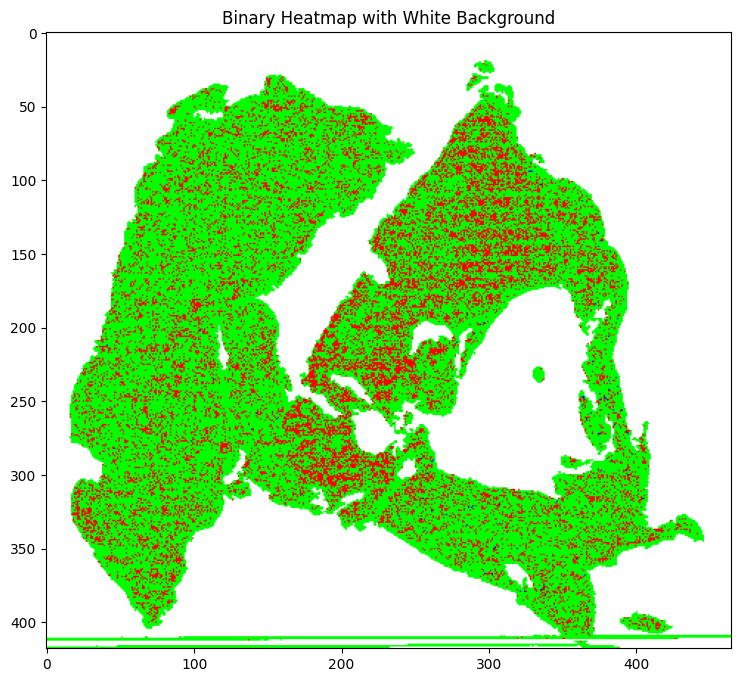

In [62]:
heatmap_stack = np.stack((heatmap_necrosis, heatmap_stroma, heatmap_viable), axis=2)

# Initialize an RGB image with the same dimensions as your heatmaps
heatmap_rgb = np.ones((*heatmap_stack.shape[:2], 3))

heatmap_rgb[..., 1] -= heatmap_stack[..., 0] 
heatmap_rgb[..., 2] -= heatmap_stack[..., 0] 

# Stroma in green 
heatmap_rgb[..., 0] -= heatmap_stack[..., 1]  
heatmap_rgb[..., 2] -= heatmap_stack[..., 1] 

# Viable in blue
heatmap_rgb[..., 0] -= heatmap_stack[..., 2]  #
heatmap_rgb[..., 1] -= heatmap_stack[..., 2]  

# Ensure that the values are within the valid range [0, 1]
heatmap_rgb = np.clip(heatmap_rgb, 0, 1)

# Plotting
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_rgb)
plt.title('Binary Heatmap with White Background')
plt.show()